In [1]:
# Ensure TensorFlow 2.0 is installed.
!pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension.
%load_ext tensorboard

     |████████████████████████████████| 95.2MB 119kB/s 
     |████████████████████████████████| 3.8MB 38.7MB/s 
     |████████████████████████████████| 450kB 45.3MB/s 
     |████████████████████████████████| 81kB 13.6MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
ERROR: tb-nightly 2.1.0a20191116 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.


In [5]:
!nvidia-smi
# !pip install tensorboardcolab
!mkdir lib
!mv data_preprocess.py evaluate.py lib

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')

# from tensorboardcolab import TensorBoardColab
# tbc = TensorBoardColab(graph_path='/content/sample_data')

Sun Nov 17 10:54:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
import re
import nltk
import sklearn
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

from pprint              import pprint
from bokeh.io            import output_notebook, show
from bokeh.models        import ColumnDataSource
from bokeh.palettes      import Spectral6
from bokeh.plotting      import figure
from lib.data_preprocess import Preprocess
from nltk.corpus         import stopwords 
from nltk.tokenize       import word_tokenize
from nltk.stem           import WordNetLemmatizer
from bs4                 import BeautifulSoup
from PIL                 import Image
from wordcloud           import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm                import tqdm_notebook as tqdm
from scipy               import stats

# plot setting
output_notebook()
sns.set_style('whitegrid')
param = {'figure.figsize': (16, 8),
         'axes.titlesize': 18,
         'axes.labelsize': 16}
plt.rcParams.update(param)

# ntlk setting
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# %load_ext tensorboard

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data preprocessing

In [7]:
label_path   = 'gdrive/My Drive/dataset/IMDB/labeledTrainData.tsv'
unlabel_path = 'gdrive/My Drive/dataset/IMDB/unlabeledTrainData.tsv'
add_path     = 'gdrive/My Drive/dataset/IMDB/imdb_master.csv'
test_path    = 'gdrive/My Drive/dataset/IMDB/testData.tsv'

# read in the dataset
pp                = Preprocess()
unlabel_df        = pd.read_csv(unlabel_path, error_bad_lines=False, delimiter='\t')
add_df            = pd.read_csv(add_path, error_bad_lines=False, delimiter=',', encoding='latin_1')[['review', 'label']]
train_df, test_df = pp.read_file(label_path, test_path, sep='\t')

# rename the add_df's column name to match with IMDB dataset
add_df.columns      = ['review','sentiment']
add_df['sentiment'] = add_df['sentiment'].apply(lambda x: 0 if x == 'neg' else 1)

# record the twitter and train dataframe size
add_size   = add_df.shape[0]
label_size = train_df.shape[0]

# check for missing value
print('Train set:')
pp.check_na(train_df)
print()

print('Unlabel data set:')
pp.check_na(unlabel_df)
print()

print('Additional dataset:')
pp.check_na(add_df)
print()

print('Test set:')
pp.check_na(test_df)

b'Skipping line 43043: expected 2 fields, saw 3\n'


Train set:
============== Data Info ==============
Number of rows: 25000
Number of cols: 3
========== Missing Data Info ==========
     Columns  Count DataType
0         id      0   object
1  sentiment      0    int64
2     review      0   object

Unlabel data set:
============== Data Info ==============
Number of rows: 49998
Number of cols: 2
========== Missing Data Info ==========
  Columns  Count DataType
0      id      0   object
1  review      0   object

Additional dataset:
============== Data Info ==============
Number of rows: 100000
Number of cols: 2
========== Missing Data Info ==========
     Columns  Count DataType
0     review      0   object
1  sentiment      0    int64

Test set:
============== Data Info ==============
Number of rows: 25000
Number of cols: 2
========== Missing Data Info ==========
  Columns  Count DataType
0      id      0   object
1  review      0   object


In [8]:
def text_process(df):
    # convert it to lower space
    df.review = df.review.str.lower()

    # pattern
    nw_removal  = lambda review: re.sub(r'[^A-Za-z\s]', ' ', review)
    spc_removal = lambda review: re.sub(r'[\s]+'      , ' ', review)
    tag_removal = lambda review: BeautifulSoup(review, 'lxml').get_text()

    # replace words or substrings which match the pattern
    df.review = df.review.apply(tag_removal)
    df.review = df.review.apply(nw_removal)
    df.review = df.review.apply(spc_removal)
    
    return df

def lemmatize(review):
    lemmatization = WordNetLemmatizer()
    stop_words    = set(stopwords.words('english'))
    
    # tokenize, lemmatize and stop words removal
    tokens            = word_tokenize(review)
    lemmatized_tokens = list(map(lambda x: lemmatization.lemmatize(x, pos='v'), tokens))
    meaningful_tokens = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    
    return meaningful_tokens

# add in the additional dataset
add_df   = pd.concat([add_df.loc[add_df['sentiment'] == 0], add_df[add_df['sentiment'] == 1][:25000]])
train_df = pd.concat([train_df, add_df, unlabel_df,])
add_size = add_df.shape[0]

# clean the reviews
train_df = text_process(train_df)
test_df  = text_process(test_df)

# lemmatize the reviews
train_df['review_tokenized'] = list(map(lemmatize, train_df.review.values.copy()))
test_df['review_tokenized']  = list(map(lemmatize, test_df.review.values.copy()))
all_reviews                  = pd.concat([train_df['review_tokenized'], test_df['review_tokenized']]).to_numpy()

print('='*30)
print('Vocabulary Size: {}'.format(all_reviews.shape))
print('='*30)

Vocabulary Size: (99998,)


In [9]:
display(train_df[['id', 'review', 'sentiment']].head(10))

,id,review,sentiment
0,5814_8,with all this stuff going down at the moment w...,1.0
1,2381_9,the classic war of the worlds by timothy hine...,1.0
2,7759_3,the film starts with a manager nicholas bell g...,0.0
3,3630_4,it must be assumed that those who praised this...,0.0
4,9495_8,superbly trashy and wondrously unpretentious s...,1.0
5,8196_8,i dont know why people think this is such a ba...,1.0
6,7166_2,this movie could have been very good but comes...,0.0
7,10633_1,i watched this video at a friend s house i m g...,0.0
8,319_1,a friend of mine bought this film for and even...,0.0
9,8713_10,this movie is full of references like mad max ...,1.0


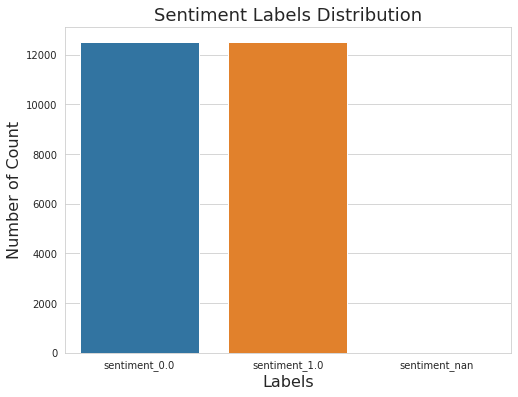

In [10]:
labels, counts = np.unique(train_df.sentiment.values, return_counts=True)
labels         = ['sentiment_' + str(label) for label in labels]

plt.figure(figsize=(8,6))
plt.title('Sentiment Labels Distribution')
plt.xlabel('Labels')
plt.ylabel('Number of Count')
sns.barplot(x=labels, y=counts)
plt.show()



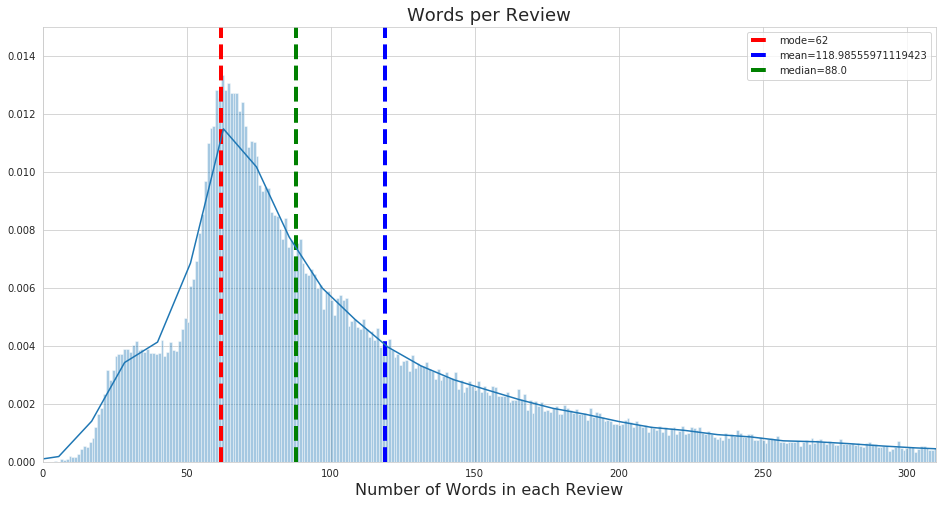

In [11]:
review_length = np.array(list(map(len, all_reviews.copy())))
mode          = stats.mode(review_length)[0][0]
mean          = np.mean(review_length)
median        = np.median(review_length)
ymin, ymax    = 0, 0.015

plt.figure(figsize=(16,8))
plt.title('Words per Review')
plt.xlabel('Number of Words in each Review')
plt.xlim([0, np.percentile(review_length, 95)])  # check where the 95% of distribution lies on
plt.ylim([0, ymax])

plt.vlines(mode  , ymin=0, ymax=ymax, linestyle='--', linewidth=4, colors='red'  , label=f'mode={mode}')
plt.vlines(mean  , ymin=0, ymax=ymax, linestyle='--', linewidth=4, colors='blue' , label=f'mean={mean}')
plt.vlines(median, ymin=0, ymax=ymax, linestyle='--', linewidth=4, colors='green', label=f'median={median}')
sns.distplot(review_length, bins=review_length.max())

plt.legend()
plt.show()


In [0]:
from gensim.models import Phrases

bigrams  = Phrases(sentences=all_reviews)
trigrams = Phrases(sentences=bigrams[all_reviews])

# Word Embedding

In [13]:
%%time
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences

embedded_size = 180
embedding = Word2Vec(sentences=trigrams[bigrams[all_reviews]],
                     size=embedded_size, window=5, min_count=3, workers=6, sg=1)

print('Vocabulary size: {}'.format(len(embedding.wv.vocab)))

Using TensorFlow backend.


Vocabulary size: 98689
CPU times: user 26min 59s, sys: 1.59 s, total: 27min
Wall time: 15min 17s


In [14]:
embedding.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)

[('throne', 0.5423933863639832),
 ('princess', 0.5231745839118958),
 ('queen', 0.4954874515533447)]

In [15]:
embedding.most_similar('galaxy')

[('solar_system', 0.8169952630996704),
 ('interstellar', 0.7860631942749023),
 ('wormhole', 0.7796242833137512),
 ('home_planet', 0.7625678181648254),
 ('crash_land_earth', 0.75907963514328),
 ('starship', 0.7589373588562012),
 ('habitable', 0.7573219537734985),
 ('land_planet', 0.7537533044815063),
 ('asteroids', 0.7514350414276123),
 ('anti_matter', 0.7508907318115234)]

In [0]:
embedding.wv.save_word2vec_format('gdrive/My Drive/dataset/IMDB/neural_embedding_model/wv.bin')

In [0]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# X   = embedding[embedding.wv.vocab]
# X_  = pca.fit_transform(X)

# plt.figure(figsize=(12,12))
# plt.scatter(X_[:,0], X_[:,1])

# for idx, word in enumerate(list(embedding.wv.vocab)):
#     plt.annotate(word, xy=(X_[idx, 0], X_[idx, 1]))

# plt.show()

In [18]:
train_size = label_size + add_size
train_data = train_df[:train_size]
train_x, train_y = train_data['review_tokenized'].values.copy(), train_data['sentiment'].values.copy()

from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.05, shuffle=True, random_state=42)

print('='*30)
print('Training Size  :', train_x.shape[0])
print('Validation Size:', valid_x.shape[0])
print('='*30)

Training Size  : 23750
Validation Size: 1250


In [19]:
def vectorized_sentence(reviews, vocab):
    print('Vectorizing words.....', end='\r')
    
    keys           = list(vocab.keys())
    filter_unknown = lambda word  : vocab.get(word, None) is not None
    encode         = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized     = list(map(encode, reviews))
    
    print('Vectorizing words..... (done)')
    
    return vectorized


vocab   = embedding.wv.vocab
train_x = vectorized_sentence(trigrams[bigrams[train_x]], vocab)
valid_x = vectorized_sentence(trigrams[bigrams[valid_x]], vocab)

pad_length  = 180 
train_pad_x = pad_sequences(sequences=train_x, maxlen=pad_length, padding='post')
valid_pad_x = pad_sequences(sequences=valid_x, maxlen=pad_length, padding='post')

Vectorizing words..... (done)
Vectorizing words..... (done)


# Model Development

In [0]:
import tensorflow as tf

from keras.callbacks  import TensorBoard, LearningRateScheduler, Callback


def Bidirectional_LSTM(embedding_matrix, input_length):
    embedding_layer = tf.keras.layers.Embedding(embedding_matrix.shape[0],
                                embedding_matrix.shape[1], 
                                input_length=input_length,
                                weights=[embedding_matrix],
                                trainable=False)
    model = tf.keras.Sequential()
    model.add(embedding_layer)
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, recurrent_dropout=0.1)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

def lr_scheduler(epochs):
    lr = 0.001
    
    if epochs > 20  : lr = 0.0003;
    elif epochs > 40: lr = 0.0001;
    elif epochs > 60: lr = 0.00003;
        
#     tf.summary_scalar('learning_rate', data=lr, step=epochs)
    
    return lr

class LossCallback(Callback):
    def on_train_begin(self, logs={}):
        self.history = []
        
    def on_batch_end(self, batch, logs={}):
        self.history.append(logs.get('loss'))


In [21]:
net   = Bidirectional_LSTM(embedding.wv.vectors, pad_length)
optim = tf.keras.optimizers.Adam(lr=0.03, decay=0.001)
net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 180)          17764020  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               316416    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 18,096,949
Trainable params: 332,929
Non-trainable params: 17,764,020
______________________________________

$lr\_decay$ = $initial\_lr * \frac{1}{1 + decay * iteration}$

In [0]:
epochs       = 20
batch_size   = 200
log_dir      = '/content/sample_data/'
# tb_callbacks = TensorBoard(log_dir=log_dir + 'accuracy/')
# ls_callbacks = LossCallback()

tb_callbacks = tf.keras.callbacks.TensorBoard(log_dir=log_dir + 'accuracy/')
# lr_writer    = tf.summary.create_file_writer(log_dir + 'dynamic_lr/')
lr_callbacks = LearningRateScheduler(lr_scheduler)

# %tensorboard --logdir /content/sample_data

In [0]:
%%time

print('Training....', end='\r')

history = net.fit(x=train_pad_x, 
                  y=train_y, 
                  validation_data=(valid_pad_x, valid_y), 
                  batch_size=batch_size, 
                  epochs=10,
                  callbacks=[tb_callbacks])

print('Training.... (Done)')


Train on 23750 samples, validate on 1250 samples
Epoch 1/10
23750/23750 [==============================] - 231s 10ms/sample - loss: 0.6817 - accuracy: 0.5581 - val_loss: 0.6709 - val_accuracy: 0.5808
Epoch 2/10
23750/23750 [==============================] - 229s 10ms/sample - loss: 0.6342 - accuracy: 0.6387 - val_loss: 0.5945 - val_accuracy: 0.6904
Epoch 3/10
23750/23750 [==============================] - 229s 10ms/sample - loss: 0.6203 - accuracy: 0.6575 - val_loss: 0.6430 - val_accuracy: 0.6360
Epoch 4/10
14200/23750 [================>.............] - ETA: 1:30 - loss: 0.5985 - accuracy: 0.6823

In [0]:
def model_save(model, history):
    losses = [[t_loss, v_loss] for t_loss, v_loss in zip(history['loss'], history['val_loss'])]
    acc    = [[t_acc , v_acc]  for t_acc , v_acc  in zip(history['accuracy'], history['val_accuracy'])]

    model.save_weights('gdrive/My Drive/dataset/IMDB/model.h5')
    np.savetxt('gdrive/My Drive/dataset/IMDB/losses.csv'  , losses, delimiter=',')
    np.savetxt('gdrive/My Drive/dataset/IMDB/accuracy.csv', acc, delimiter=',')

model_save(net, history.history)


# Metrics

In [0]:
from lib.evaluate import Evaluation as Eval

eval = Eval()
train_y_ = np.round(net.predict(train_pad_x).squeeze())
valid_y_ = np.round(net.predict(valid_pad_x).squeeze())

train_acc = eval.classification_accuracy(train_y, train_y_)
valid_acc = eval.classification_accuracy(valid_y, valid_y_)

eval.pretty_print_acc(train_acc, valid_acc)

In [0]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.title('Train VS Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.scatter(range(len(train_loss)), train_loss, label='Train', c='r')
plt.plot(range(len(valid_loss)), valid_loss, label='Valid', linewidth=3)
plt.legend()

plt.subplot(1,2,2)
plt.title('Train VS Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.scatter(range(len(train_acc)), train_acc, label='Train', c='r')
plt.plot(range(len(valid_acc)), valid_acc, label='Valid', linewidth=3)
plt.legend()

plt.show()

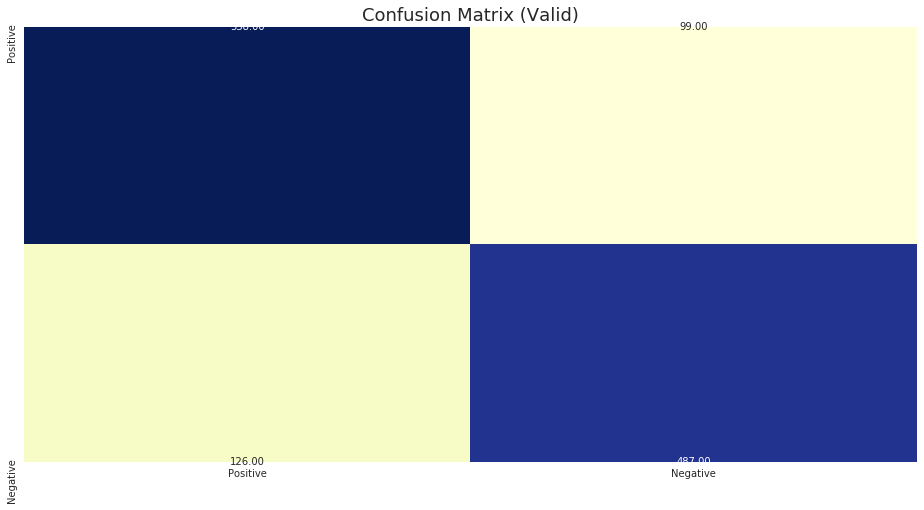

In [27]:
eval.plot_confusion_matrix(valid_y, valid_y_.squeeze(), title='Confusion Matrix (Valid)')
plt.show()

In [0]:
fpr, tpr, threshold = roc_curve(val_y, val_y_)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(16,8))
plt.title('AUC, ROC score')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr, label=f"AUC score: {auc_score}")
plt.show()